## Factor Analysis and Construction of Sensitivity-Resilience-Exposure (S-R-E) Scores

This notebook implements the full **factor analysis pipeline** used to derive the **Sensitivity, Resilience, and Exposure (S-R-E)** dimensions of labor vulnerability from pooled survey data. It serves as the methodological bridge between raw indicators and the final index-ready factor scores.

**The main objectives of this notebook are to:**
- Pool imputed monthly survey datasets into a single analytical sample
- Assess the suitability of the data for factor analysis
- Empirically validate the S-R-E framework using statistical criteria
- Extract and rotate latent factors from observed behavioral indicators
- Generate individual-level **Sensitivity, Exposure, and Resilience scores**
- Reattach these scores back to the original monthly survey files

This process ensures that the constructed S-R-E pillars are **data-driven, empirically validated, and consistent across time**.

### Factor Analysis
Factor Analysis is applied to reduce the labor-related and demographic indicators into interpretable dimensions. This allows complex employment behaviors and demographic conditions to be summarized into coherent vulnerability pillars that can be used for regional vulnerability index construction.

#### Output Location
All final survey datasets containing the original variables **plus the computed S-R-E factor scores** are saved in: `Survey Datasets with Factor Scores`

Each monthly file in this directory preserves the full survey structure while adding:
- `Sensitivity_Score`
- `Exposure_Score`
- `Resilience_Score`

These datasets are the primary inputs for index computation.

---
### Data Pooling and Preparation

The analysis begins by consolidating individual monthly survey files into a single, unified dataset, creating a comprehensive baseline for uncovering latent population patterns.

- **Selection of Representative Data:** Although five imputed versions were generated to address missing values, <u>Version 1 is selected as the representative dataset for Factor Analysis</u>. This choice is <u>justified by the statistical stability observed across all versions during imputation validation</u>, ensuring methodological consistency while maintaining computational efficiency for a large-scale dataset.
- **Variable Selection and Traceability:** The dataset includes 15 variables capturing labor behaviors and demographic characteristics. Key survey identifiers (`Survey_Year`, `Survey_Month`, `Psu_Number`, `C101_Line_Number`, and `Replicate`) are preserved but excluded from Factor Analysis. These variables are not drivers of vulnerability, but they serve as anchors to enable calculated scores to be traced back to original survey units and aggregated at the regional level.

To manage the large volume of observations efficiently, only the relevant variables and identifiers are loaded from each monthly file. The resulting pooled dataframe provides scope and serves as the foundation for subsequent factor extraction and index construction.

In [1]:
import json
from pathlib import Path
import os
import pandas as pd
import numpy as np


# --- 1. LOAD CONFIGURATION ---
try:
    with open(Path("./data/interim/config.json")) as f:
        cfg = json.load(f)
    BASE_PATH = Path(cfg["BASE_PATH"])
    OUTPUT_ROOT = BASE_PATH / "Imputed Monthly Datasets"
    print(f" Configuration Loaded. Path: {OUTPUT_ROOT}")
except Exception as e:
    print(f" Error loading config: {e}")


# --- 2. DEFINE VARIABLES & IDENTIFIERS ---
behavioral_vars = [
    'Work_Indicator', 'C04_Sex', 'Available_for_Work', 'Look_for_Additional_Work',
    'Looked_for_Work_or_Tried_to_Establish_Business_During_the_Past_Week',
    'Previous_Job_Indicator', 'Want_More_Hours_of_Work', 'Other_Job_Indicator',
    'C03_Relationship_to_Household_Head', 'C06_Marital_Status',
    'New_Employment_Criteria_jul_05_2005', 'C05_Age_as_of_Last_Birthday',
    'Normal_Working_Hours_per_Day', 'Total_Hours_Worked_for_all_Jobs', 'Household_Size'
]


# These are critical for redistributing results back to regions/months later
identifiers = ['Survey_Year', 'Survey_Month', 'Psu_Number', 'C101_Line_Number', 'Replicate']


# --- 3. POOLING VERSION 1 DATASETS ---
pooled_list = []


if not OUTPUT_ROOT.exists():
    print(f" Warning: Directory not found at {OUTPUT_ROOT}")
else:
    print(f" Pooling Version 1 datasets...")
   
    # Get all month folders
    month_folders = sorted([f for f in os.listdir(OUTPUT_ROOT) if (OUTPUT_ROOT / f).is_dir()])


    for folder in month_folders:
        month_path = OUTPUT_ROOT / folder
        # We strictly use Version 1 for the Factor Analysis baseline
        v1_file = list(month_path.glob("Imputed_v1_*.csv"))
       
        if v1_file:
            # Load only the variables we need to save RAM
            df = pd.read_csv(v1_file[0], usecols=behavioral_vars + identifiers)
            pooled_list.append(df)
            print(f"  Added: {folder}...", end="\r")


    if pooled_list:
        df_pooled = pd.concat(pooled_list, axis=0).reset_index(drop=True)
        print(f"\n\n DATA POOLING COMPLETE")
        print(f"Total Observations (Rows): {len(df_pooled):,}")
        print(f"Total Columns: {len(df_pooled.columns)}")
    else:
        print("\n No files found. Please check folder names.")

 Configuration Loaded. Path: H:\.shortcut-targets-by-id\1VctTphaltRx4xcPxmTJlRTrxLalyuEt8\Labor Force Survey\Imputed Monthly Datasets
 Pooling Version 1 datasets...
  Added: 2024_May.........

 DATA POOLING COMPLETE
Total Observations (Rows): 5,986,548
Total Columns: 20


---
### Suitability Assessment for Factor Analysis

Before starting Factor Analysis, we need to make sure the data is suitable and the variables are related enough to find meaningful patterns. Two standard checks are applied to the pooled Version 1 dataset:

- **Bartlett’s Test of Sphericity:** This test checks whether the variables are related to each other. If the test is significant (p-value < 0.05), it means there is enough relationship between variables to proceed with factor analysis.

- **Kaiser-Meyer-Olkin (KMO) Measure:** This test looks at whether the data is strong enough for identifying underlying patterns. Overall KMO values above 0.6 are considered good, while individual variables with KMO below 0.5 may not contribute well.

These tests show that the selected behavioral variables are sufficiently related and suitable for extracting the underlying factors. Any variables with lower KMO values can still be kept if they are important based on theory. This ensures a solid foundation for subsequent factor extraction and construction of RFVI.

In [2]:
from factor_analyzer import calculate_kmo, calculate_bartlett_sphericity
import pandas as pd

# --- 1. DATA SELECTION ---
target_df = df_pooled[behavioral_vars]

print(f" Running Suitability Tests on {len(target_df):,} observations...")

try:
    # --- 2. BARTLETT'S TEST OF SPHERICITY ---
    chi_square, p_value = calculate_bartlett_sphericity(target_df)
    
    # --- 3. KMO TEST (Overall and Individual) ---
    kmo_all, kmo_model = calculate_kmo(target_df)

    # --- 4. PRINT OVERALL SUMMARY ---
    print("\n" + "="*45)
    print("      OVERALL SUITABILITY RESULTS")
    print("="*45)
    # Using format for p-value as it might be extremely small (e.g., 0.000e+00)
    print(f"  Bartlett’s P-value: {p_value:.4f}")
    print(f"  Overall KMO Score:  {kmo_model:.4f}")
    print("-" * 45)

    # --- 5. INDIVIDUAL VARIABLE BREAKDOWN ---
    kmo_df = pd.DataFrame({
        'Variable': behavioral_vars,
        'KMO Score': kmo_all
    }).sort_values(by='KMO Score', ascending=False)

    print("\n INDIVIDUAL MEASURE OF SAMPLING ADEQUACY (MSA):")
    
    # FIX: Replaced .applymap() with .map() to resolve the FutureWarning
    styled_kmo = kmo_df.style.map(
        lambda x: 'color: red; font-weight: bold' if isinstance(x, float) and x < 0.5 else '',
        subset=['KMO Score']
    ).format({"KMO Score": "{:.4f}"})
    
    display(styled_kmo)

    # Final Check
    low_kmo = kmo_df[kmo_df['KMO Score'] < 0.5]
    if not low_kmo.empty:
        print(f"\n  WARNING: {len(low_kmo)} variables are below the 0.50 threshold.")
    else:
        print("\n All variables meet the minimum requirement for Factor Analysis.")

except Exception as e:
    print(f"\n Error during processing: {e}")

 Running Suitability Tests on 5,986,548 observations...

      OVERALL SUITABILITY RESULTS
  Bartlett’s P-value: 0.0000
  Overall KMO Score:  0.8044
---------------------------------------------

 INDIVIDUAL MEASURE OF SAMPLING ADEQUACY (MSA):


,Variable,KMO Score
7,Other_Job_Indicator,0.9283
3,Look_for_Additional_Work,0.9076
6,Want_More_Hours_of_Work,0.8965
0,Work_Indicator,0.8671
14,Household_Size,0.8484
9,C06_Marital_Status,0.8285
13,Total_Hours_Worked_for_all_Jobs,0.8190
10,New_Employment_Criteria_jul_05_2005,0.7935
12,Normal_Working_Hours_per_Day,0.7859
11,C05_Age_as_of_Last_Birthday,0.7800



 All variables meet the minimum requirement for Factor Analysis.


Key Insights:

Bartlett’s test is significant (p < 0.05), confirming that **the variables are sufficiently related to each other**. The overall KMO score is 0.804, above the 0.6 threshold, indicating **strong sampling adequacy**. Individually, most variables show high KMO values (all above 0.56), meaning they contribute well to identifying underlying factors. Overall, the results support proceeding confidently with factor extraction as the dataset is highly suitable for Factor Analysis.

---
### Theoretical Sensitivity-Resilience-Exposure (S-R-E) Mapping

Before performing Factor Analysis, the 15 behavioral indicators are assigned to the three theoretical pillars of the Regional Financial Vulnerability Index (RFVI): **Sensitivity**, **Resilience**, and **Exposure**.

This mapping provides a qualitative benchmark, allowing us to compare the theoretical expectations of variable grouping with the empirical results from Factor Analysis.

**Purpose of Each Dimension:**

- **Sensitivity:** Reflects how easily a household’s financial condition is affected by limited work opportunities and internal resource pressure. It captures labor underutilization, unmet work needs, and household dependency, indicating how vulnerable the household is to small economic changes.
- **Resilience:** Represents the demographic and behavioral characteristics that influence a household’s ability to cope with or recover from financial stress. These include age, marital status, household role, and readiness or willingness to work.
- **Exposure:** Focuses on current and recent employment conditions, measuring the extent to which individuals are directly affected by labor market risks based on their job status and employment history.

Establishing this mapping before factor extraction ensures **confirmatory interpretability**. In later steps, the factor loadings will be compared against this theoretical assignment. A close match between predicted and observed groupings provides strong evidence for the validity of this S-R-E framework.

In [3]:
# --- THEORETICAL SRE MAPPING ---
sre_theory_map = {
    'Sensitivity': [
        'Want_More_Hours_of_Work',
        'Look_for_Additional_Work',
        'Normal_Working_Hours_per_Day',
        'Total_Hours_Worked_for_all_Jobs',
        'Household_Size'
    ],
    'Resilience': [
        'C04_Sex',
        'C05_Age_as_of_Last_Birthday',
        'C06_Marital_Status',
        'C03_Relationship_to_Household_Head',
        'Available_for_Work',
        'Looked_for_Work_or_Tried_to_Establish_Business_During_the_Past_Week'
    ],
    'Exposure': [
        'Work_Indicator',
        'Previous_Job_Indicator',
        'New_Employment_Criteria_jul_05_2005',
        'Other_Job_Indicator'
    ]
}

# Print a clean summary for your records
print(" Theoretical SRE Mapping Established:")
for concept, vars in sre_theory_map.items():
    print(f"{concept:12}: {', '.join(vars)}")

 Theoretical SRE Mapping Established:
Sensitivity : Want_More_Hours_of_Work, Look_for_Additional_Work, Normal_Working_Hours_per_Day, Total_Hours_Worked_for_all_Jobs, Household_Size
Resilience  : C04_Sex, C05_Age_as_of_Last_Birthday, C06_Marital_Status, C03_Relationship_to_Household_Head, Available_for_Work, Looked_for_Work_or_Tried_to_Establish_Business_During_the_Past_Week
Exposure    : Work_Indicator, Previous_Job_Indicator, New_Employment_Criteria_jul_05_2005, Other_Job_Indicator


---
### Eigenvalue Extraction and Scree Plot Assessment

To determine how many underlying factors exist among the behavioral indicators, the dataset is examined through its eigenvalues and the scree plot. This step checks whether the three RFVI pillars **(Sensitivity, Resilience, and Exposure)** are supported by real patterns in the data.

Factor Analysis works by identifying hidden factors that explain the shared variation among variables. Variation refers to how much values differ across observations. When variables change together in consistent ways, it indicates structured variation, suggesting that an underlying factor may be driving those patterns. Eigenvalues measure how much of this total variation each factor explains.

**Kaiser Criterion (Eigenvalue > 1):**
Each factor is assigned an eigenvalue.
- **Eigenvalue > 1.0:** The factor explains more variation than a single original variable and is considered meaningful.
- **Eigenvalue < 1.0:** The factor explains little variation and is usually treated as noise.

**Visual check using the Scree Plot:**
- **Y-axis:** Eigenvalue (amount of variation explained)
- **X-axis:** Factor number
- **Red line (Eigenvalue = 1):** Minimum threshold for retaining a factor.

The scree plot typically shows a steep drop followed by a flatter curve. The point where the curve begins to flatten (the **“elbow”**) indicates where meaningful factors end and random noise begins.

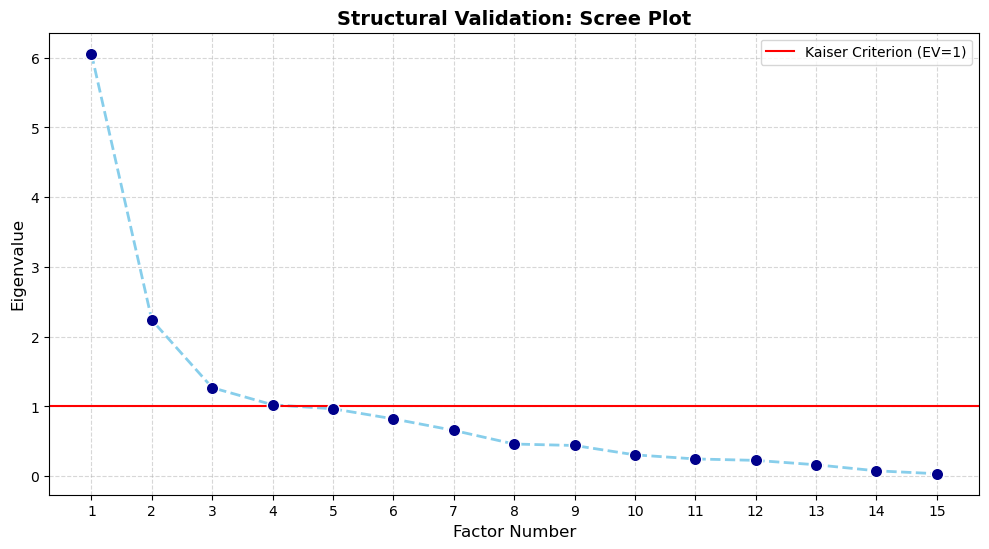

------------------------------
 RESULTS SUMMARY:
Factors with Eigenvalues > 1: 4
------------------------------
Factor  1: 6.0567
Factor  2: 2.2389
Factor  3: 1.2696
Factor  4: 1.0243
Factor  5: 0.9670
Factor  6: 0.8224
Factor  7: 0.6574
Factor  8: 0.4618
Factor  9: 0.4410
Factor 10: 0.3066
Factor 11: 0.2482
Factor 12: 0.2275
Factor 13: 0.1646
Factor 14: 0.0778
Factor 15: 0.0363


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# --- STEP 3: NATIVE EIGENVALUE CALCULATION ---

# 1. Calculate the Correlation Matrix
corr_matrix = df_pooled[behavioral_vars].corr()

# 2. Extract and sort Eigenvalues using NumPy's Linear Algebra engine
eigenvalues = sorted(np.linalg.eigvals(corr_matrix), reverse=True)

# 3. Visualization
plt.figure(figsize=(12, 6))
plt.scatter(range(1, len(eigenvalues) + 1), eigenvalues, color='darkblue', s=80, edgecolors='white', zorder=3)
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, color='skyblue', linestyle='--', lw=2, zorder=2)
plt.axhline(y=1, color='red', linestyle='-', linewidth=1.5, label='Kaiser Criterion (EV=1)')

plt.title('Structural Validation: Scree Plot', fontsize=14, fontweight='bold')
plt.xlabel('Factor Number', fontsize=12)
plt.ylabel('Eigenvalue', fontsize=12)
plt.xticks(range(1, len(eigenvalues) + 1))
plt.grid(axis='both', linestyle='--', alpha=0.5)
plt.legend()
plt.show()

# --- 4. NUMERIC SUMMARY ---
print("-" * 30)
print(f" RESULTS SUMMARY:")
factors_above_1 = sum(1 for x in eigenvalues if x > 1)
print(f"Factors with Eigenvalues > 1: {factors_above_1}")
print("-" * 30)
for i, val in enumerate(eigenvalues):
    print(f"Factor {i+1:2}: {val:.4f}")

#### Interpretation of Eigenvalue and Scree Plot Results

The eigenvalues and scree plot suggest that the data are best represented by **four underlying factors**. This conclusion is supported by both a numerical rule (the Kaiser Criterion) and a visual inspection of the scree plot.

Using the Kaiser Criterion, factors are kept if they explain more variation than a single original variable (eigenvalue greater than 1). In this analysis, **four factors meet this requirement**, while the next factor falls below the threshold and is therefore excluded.

The scree plot shows a clear pattern where the amount of explained variation drops sharply at first and then levels off after the fourth factor. This point, known as the “elbow,” indicates where meaningful structure ends and random noise begins. These results indicate that retaining four factors captures the main patterns in the data without overfitting.

Although the study is theoretically framed around three pillars (Sensitivity, Resilience, and Exposure), **the empirical results suggest that one of these pillars may split into a more specific sub-dimension**. This reflects meaningful structure in the data rather than a weakness in the framework.

As a final validation step, **parallel analysis** is conducted next to confirm that the fourth factor represents real structure and not random variation.


---
### Parallel Analysis for Factor Retention

To obtain a more statistically rigorous decision on the number of factors, a **parallel analysis** is conducted. This method serves as a final validation step after the Kaiser Criterion and scree plot assessment.

Parallel analysis works by comparing the dataset’s eigenvalues with those produced from **randomly generated data** of the same size. This allows the analysis to distinguish between **real structural patterns** and variation that could occur purely by chance.

**Core principle:**
- Each factor from the real dataset has an eigenvalue.
- A simulated dataset with no real structure is generated multiple times.
- Eigenvalues are extracted from these random datasets.
- The real eigenvalues are then compared to the random ones.

**Retention rule:**
- If a real eigenvalue is **greater than the corresponding random eigenvalue**, the factor explains more variation than random noise and is retained.
- If a real eigenvalue is **smaller**, the factor is considered statistically insignificant and discarded.

**Visual interpretation:**
- The scree plot displays two curves:
  - **Real data line:** Eigenvalues from the actual dataset.
  - **Random data line:** Eigenvalues from simulated noise.
- The meaningful factors are those where the **real line stays above the random line.**
- The point where the real line falls below the random line marks the transition from **true structure to noise.**

The number of factors where the real eigenvalues exceed the simulated ones represents the **statistically supported factor structure.** This result provides the most defensible basis for determining whether the RFVI should follow a **three-factor or four-factor structure**, ensuring that the final index reflects genuine patterns in the data rather than random variation.

 Step 1: Calculating Real Correlation Matrix for 5,986,548 rows...
 Step 2: Extracting Real Eigenvalues...
 Step 3: Running Parallel Analysis (20 random iterations)...
   Completed 5/20 iterations...
   Completed 10/20 iterations...
   Completed 15/20 iterations...
   Completed 20/20 iterations...


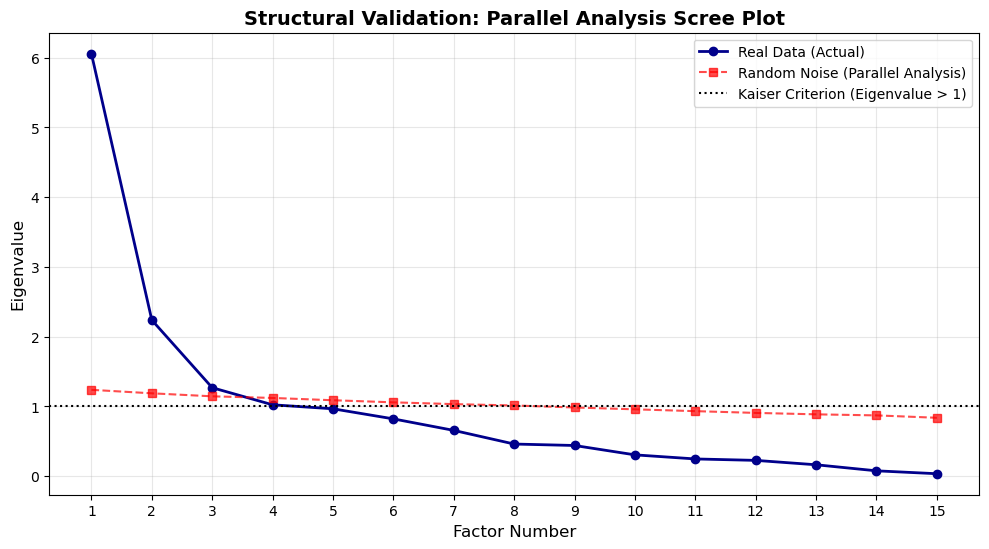

--------------------------------------------------
 FINAL RETENTION SUMMARY:
  > Factors suggested by Parallel Analysis: 3
  > Factors suggested by Kaiser Criterion:  4
--------------------------------------------------


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- OPTIMIZED PARALLEL ANALYSIS (STATISTICAL RETENTION) ---

def run_parallel_analysis_optimized(data, iterations=20, percentile=95):
    # Ensure data is a numpy array for speed
    raw_data = data.values
    n_obs, n_vars = raw_data.shape
   
    # 1. Real Eigenvalues (Optimized with NumPy)
    print(f" Step 1: Calculating Real Correlation Matrix for {n_obs:,} rows...")
    # np.corrcoef is much faster than pd.DataFrame.corr() for large datasets
    corr_matrix = np.corrcoef(raw_data, rowvar=False)
   
    print(" Step 2: Extracting Real Eigenvalues...")
    real_eigenvalues = np.linalg.eigvals(corr_matrix)
    real_eigenvalues = sorted(real_eigenvalues, reverse=True)
   
    # 2. Simulated Random Eigenvalues (Monte Carlo)
    print(f" Step 3: Running Parallel Analysis ({iterations} random iterations)...")
    sim_ev_list = []
   
    for i in range(iterations):
        # We simulate random data correlation matrix
        # 1000 rows is the statistical standard for PA simulations regardless of N_obs
        random_data = np.random.normal(0, 1, size=(1000, n_vars))
        random_corr = np.corrcoef(random_data, rowvar=False)
        sim_ev_list.append(sorted(np.linalg.eigvals(random_corr), reverse=True))
       
        if (i + 1) % 5 == 0:
            print(f"   Completed {i + 1}/{iterations} iterations...")
   
    # Get the 95th percentile of the random eigenvalues
    random_eigenvalues = np.percentile(sim_ev_list, percentile, axis=0)
   
    return real_eigenvalues, random_eigenvalues

# --- EXECUTION ---
try:
    # Use only the behavioral variables
    real_ev, rand_ev = run_parallel_analysis_optimized(df_pooled[behavioral_vars])

    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(real_ev) + 1), real_ev, 'o-', label='Real Data (Actual)', color='darkblue', linewidth=2)
    plt.plot(range(1, len(rand_ev) + 1), rand_ev, 's--', label='Random Noise (Parallel Analysis)', color='red', alpha=0.7)
    plt.axhline(y=1, color='black', linestyle=':', label='Kaiser Criterion (Eigenvalue > 1)')
   
    plt.title('Structural Validation: Parallel Analysis Scree Plot', fontsize=14, fontweight='bold')
    plt.xlabel('Factor Number', fontsize=12)
    plt.ylabel('Eigenvalue', fontsize=12)
    plt.xticks(range(1, len(real_ev) + 1))
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # Statistical Conclusion
    pa_factors = sum(1 for r, s in zip(real_ev, rand_ev) if r > s)
    kaiser_factors = sum(1 for r in real_ev if r > 1)
   
    print("-" * 50)
    print(f" FINAL RETENTION SUMMARY:")
    print(f"  > Factors suggested by Parallel Analysis: {pa_factors}")
    print(f"  > Factors suggested by Kaiser Criterion:  {kaiser_factors}")
    print("-" * 50)
   
except Exception as e:
    print(f" Error during Parallel Analysis: {e}")

#### Interpretation of Parallel Analysis Results

Parallel analysis indicates that the data support a **three-factor structure**, despite the earlier suggestion of four factors based on the Kaiser Criterion. This difference reflects a common distinction between identifying large factors and identifying factors that are truly distinct from random noise.

While the Kaiser Criterion retains factors with eigenvalues greater than 1, parallel analysis directly compares the observed data to randomly generated data. In the parallel analysis plot, the eigenvalues from the real data exceed the random-data threshold for the first three factors only. The fourth factor, although slightly above an eigenvalue of 1, falls below the random benchmark, indicating that it is not statistically distinguishable from noise.

This result confirms that **three factors represent genuine and stable patterns** in the data, which may correspond to the Sensitivity, Resilience, and Exposure pillars. The potential fourth factor appears to reflect residual or overlapping variation rather than a distinct dimension of vulnerability.

The study therefore proceeds with a **three-factor solution**, which is both statistically rigorous and fully aligned with the theoretical framework.

---
### Factor Extraction and Loading Analysis

Factor extraction reduces the shared variation among the survey indicators into a smaller set of interpretable latent dimensions. By examining factor loadings, we identify which variables move together and represent the same underlying behavioral pattern or household characteristic.

In this analysis, **Principal Axis Factoring (PAF)** is used as the extraction method. PAF focuses on the **shared variance** among variables rather than total variance, making it well-suited for uncovering latent constructs that reflect common behavioral patterns in the data.

**Promax rotation (oblique)** was applied to the extracted factors. This allows the factors to **correlate naturally**, reflecting the realistic expectation that Sensitivity, Exposure, and Resilience dimensions are related dimensions of vulnerability rather than perfectly independent phenomena. Oblique rotation improves interpretability by producing a simpler, more meaningful factor structure.

**Purpose of Factor Extraction:**
- Translate shared variation of variables into interpretable pillars.
- Identify which behavioral indicators define each dimension.
- Confirm the theoretical S-R-E framework aligns with the actual data.
- Discover underlying concepts or latent patterns that might reveal new aspects of vulnerability.

#### Rationale for Examining Three- and Four-Factor Solutions

**Three-Factor Solution:**
- Supported by **Parallel Analysis**, only the first three factors are statistically distinct from random noise.

**Why Examine a Four-Factor Solution:**
- Acts as a **verification check** to see if a fourth factor is meaningful or just noise.
- To check if no important dimension is missed.

In [6]:
import numpy as np
import pandas as pd
from factor_analyzer.rotator import Rotator

# --- MANUAL PAF (WITH SMC INITIALIZATION) ---
def run_manual_paf_final(data, vars_list, n_factors, max_iter=100, tolerance=1e-6):
   
    # 1. Compute Population Correlation Matrix
    corr = data[vars_list].corr().values
    n_vars = len(vars_list)

    # 2. INITIAL COMMUNALITY ESTIMATE: TRUE SMC
    try:
        inv_corr = np.linalg.inv(corr)
        communalities = 1 - 1 / np.diag(inv_corr)
    except np.linalg.LinAlgError:
        # Fallback to max correlation if matrix is singular (rare with clean data)
        communalities = np.array([
            max(abs(corr[i, j]) for j in range(n_vars) if i != j)
            for i in range(n_vars)
        ])

    print(f" Starting iterative PAF for {n_factors} factors...")

    for i in range(max_iter):
        # Create reduced correlation matrix
        reduced_corr = corr.copy()
        np.fill_diagonal(reduced_corr, communalities)

        # Eigen-decomposition (The core of the extraction)
        evals, evecs = np.linalg.eigh(reduced_corr)

        # Sort in descending order
        idx = np.argsort(evals)[::-1]
        evals = evals[idx]
        evecs = evecs[:, idx]

        # Calculate Loadings
        loadings = evecs[:, :n_factors] * np.sqrt(np.maximum(evals[:n_factors], 0))

        # Update Communalities (Sum of squared loadings)
        new_communalities = np.sum(loadings**2, axis=1)

        # Check for convergence
        diff = np.max(np.abs(communalities - new_communalities))
        if diff < tolerance:
            print(f" Converged after {i+1} iterations (Delta: {diff:.2e})")
            break

        communalities = new_communalities

    else:
        print(" Warning: Did not converge.")

    # 3. Promax Rotation (Oblique)
    print(" Applying Promax Rotation...")
    rotator = Rotator(method='promax')
    rotated_loadings = rotator.fit_transform(loadings)

    return pd.DataFrame(
        rotated_loadings,
        index=vars_list,
        columns=[f'F{i+1}' for i in range(n_factors)]
    )

# --- EXECUTION ---
try:
    print(f" Running Final PAF Analysis on {len(df_pooled):,} observations...")

    L3 = run_manual_paf_final(df_pooled, behavioral_vars, 3)
    L4 = run_manual_paf_final(df_pooled, behavioral_vars, 4)

    print("\n 3-FACTOR LOADING MATRIX (The S-R-E Framework):")
    display(L3.style.background_gradient(cmap='RdYlGn', axis=None))

    print("\n 4-FACTOR LOADING MATRIX (The Empirical Alternative):")
    display(L4.style.background_gradient(cmap='RdYlGn', axis=None))

except Exception as e:
    print(f" Error: {e}")

 Running Final PAF Analysis on 5,986,548 observations...
 Starting iterative PAF for 3 factors...
 Converged after 62 iterations (Delta: 9.06e-07)
 Applying Promax Rotation...
 Starting iterative PAF for 4 factors...
 Converged after 68 iterations (Delta: 9.42e-07)
 Applying Promax Rotation...

 3-FACTOR LOADING MATRIX (The S-R-E Framework):


,F1,F2,F3
Work_Indicator,-0.702016,0.289969,0.077655
C04_Sex,-0.183775,0.088629,-0.230906
Available_for_Work,-0.104743,0.912664,0.035505
Look_for_Additional_Work,0.828081,0.010846,0.012172
Looked_for_Work_or_Tried_to_Establish_Business_During_the_Past_Week,-0.186965,0.881337,-0.009080
Previous_Job_Indicator,0.171258,0.237886,0.448592
Want_More_Hours_of_Work,0.707381,0.028695,0.031197
Other_Job_Indicator,0.736796,-0.004491,0.007235
C03_Relationship_to_Household_Head,-0.022141,-0.050133,0.806567
C06_Marital_Status,0.207709,-0.042444,-0.322248



 4-FACTOR LOADING MATRIX (The Empirical Alternative):


,F1,F2,F3,F4
Work_Indicator,-0.707943,0.239448,0.092779,0.057981
C04_Sex,-0.275895,0.054297,-0.234030,-0.059573
Available_for_Work,-0.093104,0.909304,0.008990,0.101013
Look_for_Additional_Work,0.066865,-0.080929,0.030160,-0.879538
Looked_for_Work_or_Tried_to_Establish_Business_During_the_Past_Week,-0.212994,0.838587,-0.039850,0.076654
Previous_Job_Indicator,0.119153,0.231202,0.439852,-0.064168
Want_More_Hours_of_Work,0.014784,-0.061056,0.045585,-0.786435
Other_Job_Indicator,0.310006,-0.049538,-0.006509,-0.480535
C03_Relationship_to_Household_Head,0.014238,-0.043119,0.831165,-0.019641
C06_Marital_Status,0.253128,-0.017013,-0.336047,0.051582


#### Factor Extraction and Loading Interpretation

Factor Analysis reduces the variation in the 15 behavioral indicators into three main underlying pillars. The three-factor solution, confirmed by Parallel Analysis, aligns closely with the theoretical **S-R-E framework**. Loadings with absolute values greater than **0.4** are considered significant contributors to each factor. A positive relationship indicates that two variables move in the same direction, meaning they increase or decrease together, while a negative relationship describes variables that move in opposite directions, where the increase of one corresponds to the decrease of the other.

---
**Factor 1: Sensitivity (Labor Adjustment Behavior)**

This factor is defined by variables related to **adjustments in work intensity** and the **pursuit of additional employment opportunities.**

**Strong loadings:**
- New_Employment_Criteria (0.919)
- Look_for_Additional_Work (0.828)
- Other_Job_Indicator (0.737)
- Want_More_Hours_of_Work (0.707)
- Normal_Working_Hours_per_Day (-0.912)
- Total_Hours_Worked_for_all_Jobs (-0.833)
- Work_Indicator (-0.702)

Interpretation: 

Sensitivity represents how strongly a worker’s current labor situation responds to economic pressures. The positively loaded variables capture behaviors that signal **unmet labor needs**, such as looking for additional work, wanting more hours, or setting new employment criteria. In contrast, the negatively loaded variables reflect ****actual work intensity and work status****, such as hours worked and whether the person is currently working.

The inverse relationship indicates that individuals with **lower current work intensity** tend to exhibit **stronger adjustment behaviors**, such as searching for more work or wanting additional hours. This pattern reflects a state of labor vulnerability where small economic changes can significantly affect the worker’s situation. Therefore, these variables collectively define the **Sensitivity** dimension.

---
**Factor 2: Exposure (Job Search and Availability)**

This factor is primarily driven by variables associated with **availability for work** and **active job-seeking behavior**.

**Strong loadings:**
- Available_for_Work (0.913)
- Looked_for_Work_or_Tried_to_Establish_Business (0.881)

Interpretation: 

Exposure reflects the degree to which an individual is **directly engaged with and dependent on the labor market** for employment. Both variables represent core components of labor market participation: being available for work and actively seeking employment or starting a business.

These indicators move together because individuals who are actively searching for work are also typically available to start employment. This reflects a state of **direct exposure to labor market risks**, such as unemployment, job competition, and economic fluctuations. Since these variables capture immediate interaction with the labor market, they collectively define the **Exposure** dimension.

---
**Factor 3: Resilience (Demographic and Household Anchors)**

This factor is defined by **demographic** and **household-structure** variables.

**Strong loadings:**
- Relationship_to_Household_Head (0.807)
- Age (0.549)
- Previous_Job_Indicator (0.449)

Interpretation: 

Resilience represents the **structural and life-cycle characteristics** that influence an individual’s capacity to withstand labor market shocks. Age reflects accumulated experience and position in the life cycle, while previous job experience indicates familiarity with the labor market. Relationship to the household head captures **household role and potential support structures**, which can affect economic stability and decision-making.

These variables move together because they describe relatively **stable, long-term characteristics** rather than short-term labor adjustments. Such characteristics often determine a person’s ability to cope with employment disruptions, access support, or re-enter the workforce. This shared structural pattern forms the **Resilience** dimension.

---
#### Why the Three-Factor Solution Was Retained

In the four-factor solution, the indicators *Look for Additional Work*, *Want More Hours of Work*, and *Other Job Indicator* separated from Factor 1 and formed a fourth factor. This new factor **did not represent a distinct type of vulnerability**. Instead, it simply split an existing set of closely related sensitivity indicators.

The three-factor model keeps these indicators together under a single Sensitivity factor, making the results **easier to understand and more coherent**. Each factor in the three-factor solution is supported by several strong loadings, while the fourth factor in the alternative model is driven by only a few variables.

For these reasons, the three-factor solution is selected. It is simpler, more stable, and directly aligned with the Sensitivity-Resilience-Exposure (S-R-E) framework of the study.

---
**Overall Insight**

The results show that the variables naturally cluster into three coherent groups, each representing a distinct behavioral or structural pattern. This indicates that the Sensitivity, Exposure, and Resilience pillars are **not only theoretical constructs** but are also **supported by the empirical relationships observed in the data**.

---
### Cross-Loading Diagnostic Check

After extracting and interpreting the factors, an additional diagnostic step is performed to assess **cross-loadings**. Cross-loading occurs when a variable shows a strong association with more than one factor at the same time (> 0.4). This can indicate that the factors are not clearly separated.

The purpose of this step is to evaluate the **clarity and purity of the factor structure**. In a well-defined model, each indicator should primarily relate to one factor only, reinforcing the interpretation that each pillar captures a distinct aspect of vulnerability.

This procedure identifies indicators whose absolute factor loadings exceed a specified threshold (0.4) on more than one factor. Such cases would suggest that the indicator is simultaneously measuring multiple dimensions, potentially weakening the conceptual distinction between the factors.

In [7]:
def check_cross_loadings(loadings_df, threshold=0.40):
    # Calculate the absolute values
    abs_loadings = loadings_df.abs()
   
    # Identify variables where more than one factor meets the threshold
    cross_loading_mask = (abs_loadings >= threshold).sum(axis=1) > 1
    cross_loading_vars = loadings_df[cross_loading_mask]
   
    if not cross_loading_vars.empty:
        print(f" Found {len(cross_loading_vars)} cross-loading variables (Threshold: {threshold}):")
        return cross_loading_vars.style.background_gradient(cmap='OrRd', axis=None)
    else:
        print(f" No cross-loadings found above {threshold}.")
        return None

# Execution
cross_results = check_cross_loadings(L3, threshold=0.40)
if cross_results is not None:
    display(cross_results)

 No cross-loadings found above 0.4.


Key Insight:

No variables exhibit cross-loadings above the 0.4 threshold. This indicates that **each behavioral indicator is strongly associated with only one factor**, confirming that the Sensitivity, Exposure, and Resilience factors are clearly distinct. The absence of cross-loadings also shows that **the three-factor structure is stable and well-defined**, supporting its use in the construction of the vulnerability index.

---
### Model Integrity and Variance Assessment

To evaluate the quality and structure of the extracted factors, three diagnostic tables are presented: **communalities, inter-factor correlations,** and **total variance explained**. Each table serves a different purpose in validating the factor solution.

**Table 1: Variable Communalities (h²)**

This table shows the **communality** of each variable, which represents the **proportion of its variance explained by the three extracted factors.**
- Higher communality values indicate that the variable is **well represented by the factor structure.
- Lower values suggest that the variable may not strongly relate to the underlying dimensions.

Purpose:
- To assess whether each behavioral indicator meaningfully contributes to the factor model.
- To verify that the selected variables are appropriate for representing the Sensitivity, Exposure, and Resilience dimensions.

**Table 2: Inter-Factor Correlation Matrix**

This table presents the **correlations among the three extracted factors:** Sensitivity, Exposure, and Resilience.

Purpose:
- To examine whether the three pillars are **empirically distinct** from one another.
- Low correlations indicate that each factor captures a **separate dimension** of labor vulnerability.
- Moderate correlations suggest related but still distinguishable constructs.
- Very high correlations may indicate conceptual overlap between factors.

This table helps confirm whether the theoretical S-R-E structure is supported by the data.

**Table 3: Total Variance Explained**

This table summarizes how much of the **overall variability in the behavioral variables** is captured by each factor.

It includes:
- The **eigenvalue** of each factor.
- The **percentage of variance explained** by each factor.
- The **cumulative variance explained** by all three factors combined.

Purpose:
- To evaluate the **strength and adequacy** of the factor solution.
- To determine how much of the original information in the variables is retained by the three-factor model.

A higher cumulative variance indicates that the extracted factors provide a **strong summary of the data structure.**

In [8]:
from sklearn.preprocessing import StandardScaler

# Standardize values for correlation calculations
scaler = StandardScaler()
df_scaled_values = scaler.fit_transform(df_pooled[behavioral_vars])

# 1. TABLE 1: VARIABLE COMMUNALITIES (h²)
communalities = (L3**2).sum(axis=1)
comm_df = pd.DataFrame(communalities, columns=['Communality (h²)'])
comm_df = comm_df.sort_values('Communality (h²)', ascending=False)

print(" TABLE 1: VARIABLE COMMUNALITIES")
display(comm_df.style.background_gradient(cmap='YlGn', vmin=0, vmax=1))


# 2. TABLE 2: INTER-FACTOR CORRELATION MATRIX
# Calculating the relationship between the S, R, and E pillars
R_mat = df_pooled[behavioral_vars].corr().values
inv_R = np.linalg.inv(R_mat)
W = inv_R.dot(L3.values)

# Correlate the resulting factor scores to check pillar independence
factor_corr = np.corrcoef((df_scaled_values @ W).T)
f_corr_df = pd.DataFrame(
    factor_corr,
    columns=['Sensitivity (F1)', 'Exposure (F2)', 'Resilience (F3)'],
    index=['Sensitivity (F1)', 'Exposure (F2)', 'Resilience (F3)']
)

print("\n TABLE 2: INTER-FACTOR CORRELATION MATRIX")
display(f_corr_df.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1))


# 3. TABLE 3: TOTAL VARIANCE EXPLAINED
total_vars = len(behavioral_vars)
var_exp = (np.array(real_ev[:3]) / total_vars) * 100
cum_var = np.cumsum(var_exp)

var_summary = pd.DataFrame({
    'Factor': ['F1 (Sensitivity)', 'F2 (Exposure)', 'F3 (Resilience)'],
    'Eigenvalue': real_ev[:3],
    '% of Variance Explained': var_exp,
    'Cumulative %': cum_var
})

print("\n TABLE 3: TOTAL VARIANCE EXPLAINED")
display(var_summary)

 TABLE 1: VARIABLE COMMUNALITIES


,Communality (h²)
New_Employment_Criteria_jul_05_2005,0.845420
Available_for_Work,0.845187
Normal_Working_Hours_per_Day,0.838593
Looked_for_Work_or_Tried_to_Establish_Business_During_the_Past_Week,0.811792
Total_Hours_Worked_for_all_Jobs,0.710723
Look_for_Additional_Work,0.685984
C03_Relationship_to_Household_Head,0.653553
Work_Indicator,0.582939
Other_Job_Indicator,0.542940
Want_More_Hours_of_Work,0.502184



 TABLE 2: INTER-FACTOR CORRELATION MATRIX


,Sensitivity (F1),Exposure (F2),Resilience (F3)
Sensitivity (F1),1.000000,0.316515,0.265946
Exposure (F2),0.316515,1.000000,0.232527
Resilience (F3),0.265946,0.232527,1.000000



 TABLE 3: TOTAL VARIANCE EXPLAINED


,Factor,Eigenvalue,% of Variance Explained,Cumulative %
0,F1 (Sensitivity),6.056713,40.378087,40.378087
1,F2 (Exposure),2.238854,14.925693,55.303780
2,F3 (Resilience),1.269567,8.463777,63.767557


#### Interpretation of Table 1: Variable Communalities

Table 1 presents the communalities (h²) of each behavioral variable, indicating how much of each variable’s variance is explained by the three extracted factors (Sensitivity, Exposure, and Resilience).

**High Representation:** Variables such as New Employment Criteria (0.845), Available for Work (0.845), Normal Working Hours per Day (0.839), and Looked for Work or Tried to Establish Business (0.812) show high communalities, meaning they are strongly represented in the factor model. This indicates that core labor participation and job-search behaviors are central to the underlying dimensions of vulnerability.

**Moderate Representation:** Total Hours Worked (0.711), Look for Additional Work (0.686), Relationship to Head (0.654), Work Indicator (0.583), Other Job Indicator (0.543), and Want More Hours (0.502) also show moderate communalities, still contributing meaningfully to the factors.

**Low Representation:** Some variables (mostly demographic) exhibit low communalities, such as Age (0.479), Previous Job Indicator (0.287), Sex (0.095), Marital Status (0.149), and Household Size (0.039), meaning their movements are largely independent of the other economic behaviors in the model.

These results indicate that the factor model is primarily driven by labor participation and job-search behaviors, while basic demographic characteristics contribute less to the shared factor structure. This supports the idea that the extracted factors are capturing behavioral aspects of labor vulnerability rather than purely demographic traits.

---
#### Interpretation of Table 2: Inter-Factor Correlation Matrix

Table 2 presents the **correlations among the three extracted factors**: Sensitivity (F1), Exposure (F2), and Resilience (F3). As expected, each factor is perfectly correlated with itself (1.000). The important values are the correlations between different factors.

- **Sensitivity and Exposure** show a moderate positive correlation (0.317). This suggests that individuals who are more sensitive to labor market changes also tend to have higher levels of exposure to labor-related risks.

- **Sensitivity and Resilience** have a weak to moderate positive correlation (0.266). This indicates that while the two factors are related, they still represent distinct dimensions of labor conditions.

Overall, the correlations are positive but not too high, meaning **the factors are related yet conceptually separate**. This supports the use of an oblique factor model, where the dimensions of Sensitivity, Exposure, and Resilience are allowed to be connected but still measure different aspects of labor vulnerability.

---
#### Interpretation of Table 3: Total Variance Explained

Table 3 quantifies how much information from the original 15 survey variables is successfully captured by the three factors.

- **F1 (Sensitivity)**
  - Eigenvalue: 6.057
  - Explains **40.38% of the total variance**
  - Interpretation: As the **dominant factor**, Sensitivity captures the largest share of variation. This confirms that labor adjustment behaviors (demand for more work vs. actual hours) represent the most prominent dimension of vulnerability in the population.

- **F2 (Exposure)**
  - Eigenvalue: 2.239
  - Explains **14.93% of the total variance**
  - Interpretation: Exposure contributes meaningfully to explaining variability in labor market participation and job-seeking behaviors, forming a **distinct but smaller dimension** than Sensitivity.

- **F3 (Resilience)**
  - Eigenvalue: 1.270
  - Explains **8.46% of the total variance**
  - Interpretation: Resilience captures variation in demographic and household-related anchors. While smaller in magnitude, it represents a **unique structural dimension** that complements the other two factors.

- **Cumulative Variance:** The three factors together explain **63.77% of the total variance**, indicating that the **S-R-E framework effectively summarizes most of the shared patterns** in the behavioral indicators, supporting its validity for constructing the vulnerability index.

---
### Factor Scoring: Generating S-R-E Scores

Factor scoring converts the results of factor analysis into **numerical scores** for each observation, showing where they stand on the three dimensions: **Sensitivity**, **Exposure**, and **Resilience**. These scores are the foundation for building the Regional Financial Vulnerability Index (RFVI).

**Steps Overview:**
- **Standardizing Variables:** All behavioral indicators are standardized so that differences in scale do not affect the scores. This ensures that the scores reflect relationships between variables, not their raw values.
- **Calculating Factor Scores:** Each variable contributes to the scores based on its relationship with the factors. The factor scoring process combines the variables to produce a score for each observation along Sensitivity, Exposure, and Resilience.
- **Organizing Scores:** The resulting scores are placed in a table with clear column names: `Sensitivity_Score`, `Exposure_Score`, and `Resilience_Score`.
- **Adding Scores to the Dataset:** These scores are merged with the original dataset, keeping all original variables intact for reference and further analysis.

In [9]:
from sklearn.preprocessing import StandardScaler


# 1. Standardize the data (Mandatory for Factor Scoring)
print(" Standardizing behavioral variables...")
scaler = StandardScaler()
df_scaled_values = scaler.fit_transform(df_pooled[behavioral_vars])


# 2. Compute the Factor Score Coefficient Matrix (The 'Weights')
# Formula: Weights = Inverse(Correlation Matrix) @ Loading Matrix
print(" Computing Factor Score Coefficients (Regression Method)...")
R = np.corrcoef(df_scaled_values, rowvar=False)
inv_R = np.linalg.inv(R)
# We use L3 (your 3-factor solution)
weights = inv_R.dot(L3.values)


# 3. Calculate the Scores
# Matrix Multiplication: [5.9M x 15] @ [15 x 3] = [5.9M x 3]
print(" Generating individual S, E, and R scores...")
raw_scores = df_scaled_values.dot(weights)


# 4. Create the Scores DataFrame with your labels
df_scores = pd.DataFrame(
    raw_scores,
    columns=['Sensitivity_Score', 'Exposure_Score', 'Resilience_Score'],
    index=df_pooled.index
)

# 5. Attach scores back to the main dataset
df_final_indexed = pd.concat([
    df_pooled.drop(columns=behavioral_vars),
    df_scores
], axis=1)

print(f" Factor Scoring Complete for {len(df_final_indexed):,} observations.")
display(df_final_indexed[['Sensitivity_Score', 'Exposure_Score', 'Resilience_Score']].head())

 Standardizing behavioral variables...
 Computing Factor Score Coefficients (Regression Method)...
 Generating individual S, E, and R scores...
 Factor Scoring Complete for 5,986,548 observations.


,Sensitivity_Score,Exposure_Score,Resilience_Score
0,2.256547,1.615341,1.994572
1,-1.606945,-0.207016,-0.931956
2,-1.671291,-0.268085,-1.116871
3,1.837947,1.245503,0.772655
4,0.208041,-1.528650,-0.420007


---
### Merging S-R-E Scores with Survey Data

This final step attaches the computed **Sensitivity, Exposure, and Resilience scores** back to each of the original monthly survey datasets. The goal is to produce complete files that contain **all the variables** and the newly generated **factor-based scores** for every observation.

**Process Overview:**
- **Create Destination Folder:** A new directory is prepared to store the final datasets that include the S-R-E scores.

- **Loop Through Monthly Files:** The script goes through each monthly folder containing the imputed survey data.

- **Load Original Monthly Dataset:** For each month, the full imputed file is loaded. This file still contains all behavioral variables and other survey variables.

- **Select Matching Factor Scores:** From the master dataset containing the computed S-R-E scores, only the rows corresponding to the same survey year and month are selected.

- **Merge Scores with Original Data:** The S–R–E scores are joined to the original dataset using a set of unique identifier columns.
This ensures that each observation receives the correct Sensitivity, Exposure, and Resilience scores.

- **Save the Final Dataset:**

The merged file is saved into a new folder, preserving:

  - All original variables
  - All behavioral indicators
  - The newly added S-R-E scores

In [10]:
import os
import pandas as pd

# --- 1. SET UP THE NEW DESTINATION ---
FINAL_DATA_ROOT = BASE_PATH / "Survey Datasets with Factor Scores"
os.makedirs(FINAL_DATA_ROOT, exist_ok=True)

print(f" Starting SRE Score Injection (Preserving Behavioral Variables)...")

# --- 2. LOOP THROUGH THE MONTHLY FOLDERS ---
month_folders = sorted([f for f in os.listdir(OUTPUT_ROOT) if (OUTPUT_ROOT / f).is_dir()])

for folder in month_folders:
    month_path = OUTPUT_ROOT / folder
    # Locating the imputed files containing the 15 behavioral variables
    v1_files = list(month_path.glob("Imputed_v1_*.csv"))
    
    if not v1_files:
        continue
        
    v1_file = v1_files[0]
    
    # --- SKIP LOGIC ---
    new_month_folder = FINAL_DATA_ROOT / folder
    save_name = f"Final_SRE_Full_{v1_file.name}"
    save_path = new_month_folder / save_name
    
    if save_path.exists():
        print(f"   {folder} already exists. Skipping.")
        continue

    print(f"  [PROCESSING] {folder}...", end="\r")
    
    # A. Load the FULL original file 
    # This contains all behavioral variables (C04_Sex, Normal_Working_Hours_per_Day, etc.)
    df_original = pd.read_csv(v1_file)
    
    # B. Filter the master SRE results for this specific time slice
    year_val = df_original['Survey_Year'].iloc[0]
    month_val = df_original['Survey_Month'].iloc[0]
    
    df_scores_subset = df_final_indexed[
        (df_final_indexed['Survey_Year'] == year_val) & 
        (df_final_indexed['Survey_Month'] == month_val)
    ]
    
    # C. MERGE: Attach scores using the composite identifier key
    df_merged = pd.merge(
        df_original, 
        df_scores_subset[identifiers + ['Sensitivity_Score', 'Exposure_Score', 'Resilience_Score']],
        on=identifiers,
        how='left'
    )
    
    # D. SAVE: Maintaining original numerical values and technical names
    os.makedirs(new_month_folder, exist_ok=True)
    df_merged.to_csv(save_path, index=False)
    
    # Clear memory to prevent crashes during the 5.9M row loop
    del df_original, df_merged, df_scores_subset

print(f"\n SUCCESS. All scores injected. Final files include all behavioral indicators and S-R-E pillars.")

 Starting SRE Score Injection (Preserving Behavioral Variables)...


C:\Users\Faith\AppData\Local\Temp\ipykernel_20196\2733850446.py:36: DtypeWarning: Columns (24,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df_original = pd.read_csv(v1_file)


  [PROCESSING] 2024_May.........
 SUCCESS. All scores injected. Final files include all behavioral indicators and S-R-E pillars.


Result:

Each monthly survey dataset is transformed into a **final version** that includes all the survey variables and the computed S-R-E factor scores. These files are now ready for the **RFVI computation, aggregation, and clustering steps** in the subsequent notebooks.